# Module 4 - Explore the Graph

This module has the following objectives:
1. Running Cypher queries to better understand the data
2. Deduplicating definitions that are very similar
3. Use GDS to find useful patterns in the Graph

Import our usual suspects (and some more...)

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from graphdatascience import GraphDataScience
from neo4j import Query, GraphDatabase, RoutingControl, Result
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings
import matplotlib.pyplot as plt
import seaborn as sns

/home/martijn/.cache/pypoetry/virtualenvs/rabobank-workshop-genai-DPgl1B5U-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

Load env variables

In [2]:
env_file = 'credentials.env'

In [3]:
if os.path.exists(env_file):
    load_dotenv(env_file, override=True)

    # Neo4j
    HOST = os.getenv('NEO4J_URI')
    USERNAME = os.getenv('NEO4J_USERNAME')
    PASSWORD = os.getenv('NEO4J_PASSWORD')
    DATABASE = os.getenv('NEO4J_DATABASE')

    # AI
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
    os.environ['OPENAI_API_KEY']=OPENAI_API_KEY
    LLM = os.getenv('LLM')
    EMBEDDINGS_MODEL = os.getenv('EMBEDDINGS_MODEL')
else:
    print(f"File {env_file} not found.")

Connect to neo4j db

In [4]:
driver = GraphDatabase.driver(
    HOST,
    auth=(USERNAME, PASSWORD)
)

In case we want to split large files

In [5]:
def split_dataframe(df, chunk_size = 50_000):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

Test the connection

In [6]:
driver.execute_query(
    """
    MATCH (n) RETURN COUNT(n) as Count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,Count
0,1494


## Explore the graph 

Now to the database and observe what is there. Example queries:

- `MATCH (n:Customer) RETURN n LIMIT 25`

- `MATCH (n:Chunk) RETURN n LIMIT 25`

- `MATCH p=()-[r:PART_OF]->() RETURN p LIMIT 25`

We can also run this via the [Neo4j Python Driver](https://neo4j.com/docs/python-manual/5/) wihtin your Notebook. Let's do so below!

### How many Customers are there in the graph?

In [7]:
driver.execute_query(
    """
    MATCH (cust:Customer) 
    RETURN COUNT(cust)
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,COUNT(cust)
0,50


### What products do customers have? 

In [8]:
customer_product_df = driver.execute_query(
    """
    MATCH (cust:Customer)-[:HAS_PRODUCT]->(prod:Product)
    WITH DISTINCT cust, COLLECT(prod.name) AS products
    RETURN cust.name AS customer_name, SIZE(products) AS num_products, products LIMIT 10
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [9]:
customer_product_df

,customer_name,num_products,products
0,Rik De Vries,1,[DirectRekening Product]
1,Jan Mulder,3,"[BeleggersRekening Product, SpaarRekening Prod..."
2,Klaas Vos,1,[SpaarRekening Product]
3,Anna Vos,3,"[RaboBusiness Banking Product, BeleggersRekeni..."
4,Emma Smit,3,"[Kortlopende Reis Product, RaboBusiness Bankin..."
5,Tess Bakker,3,"[DirectRekening Product, BeleggersRekening Pro..."
6,Eva Mulder,3,"[BeleggersRekening Product, RaboBusiness Banki..."
7,Eva Meijer,2,"[DirectRekening Product, RaboBusiness Banking ..."
8,Henk Vos,3,"[DirectRekening Product, SpaarRekening Product..."
9,Tom Visser,1,[BeleggersRekening Product]


### How many products on average?

In [10]:
customer_product_df["num_products"].describe()

count    10.000000
mean      2.300000
std       0.948683
min       1.000000
25%       1.250000
50%       3.000000
75%       3.000000
max       3.000000
Name: num_products, dtype: float64

### What are the most common products?

In [11]:
product_df = driver.execute_query(
    """
    MATCH (cust:Customer)-[:HAS_PRODUCT]->(prod:Product)
    RETURN DISTINCT prod.name AS product_name, COUNT(cust) AS num_customers ORDER BY num_customers DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [12]:
product_df

,product_name,num_customers
0,BeleggersRekening Product,24
1,SpaarRekening Product,19
2,DirectRekening Product,18
3,Kortlopende Reis Product,17
4,RaboBusiness Banking Product,13


### What documents are in the database?

In [13]:
document_df = driver.execute_query(
    """
    MATCH (prod_type:ProductType)<-[:RELATED_TO]-(doc:Document) 
    RETURN DISTINCT prod_type.name AS product_type, doc.file_name AS document, doc.pages AS num_pages
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [14]:
document_df

,product_type,document,num_pages
0,Kortlopende Reis,Interpolis Short-Term Travel Insurance.pdf,22
1,SpaarRekening,Rabo SpaarRekening 2020.pdf,14
2,RaboBusiness Banking,Terms & Conditions for Online Business Service...,29
3,DirectRekening,Payment and Online Services Terms Sept 2022.pdf,80
4,BeleggersRekening,Rabo Beleggersrekening Terms 2020.pdf,25


### How many chunks are the documents split into?

In [15]:
document_chunks_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)
    WITH DISTINCT doc, COLLECT(chunk) AS chunks
    RETURN doc.file_name AS file_name, doc.pages AS pages, SIZE(chunks) AS chunk_count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [16]:
document_chunks_df

,file_name,pages,chunk_count
0,Interpolis Short-Term Travel Insurance.pdf,22,46
1,Rabo SpaarRekening 2020.pdf,14,44
2,Terms & Conditions for Online Business Service...,29,88
3,Payment and Online Services Terms Sept 2022.pdf,80,354
4,Rabo Beleggersrekening Terms 2020.pdf,25,78


---

## Extracted Definitions

Let's dive into the extracted definitions. 

Some definitions are **very similar** to each other or are **occurring in many documents and chunks**. Let's analyse this and see if we can find solutions to deal with these points!

In [17]:
definitions_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT doc, COLLECT(def) AS definitions
    RETURN doc.file_name AS file_name, SIZE(definitions) AS definition_count, [def in definitions | def.term][0] AS definition_example, [def in definitions | def.description][0] AS description_example
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [18]:
definitions_df

,file_name,definition_count,definition_example,description_example
0,Interpolis Short-Term Travel Insurance.pdf,511,Interpolis,a trade name of Achmea Schadeverzekeringen N.V...
1,Rabo SpaarRekening 2020.pdf,696,Rabo,Savings Account 2020
2,Terms & Conditions for Online Business Service...,1216,liability,significant fault of the insured
3,Payment and Online Services Terms Sept 2022.pdf,5600,Payment,Any payment transaction resulting from the pay...
4,Rabo Beleggersrekening Terms 2020.pdf,1345,Rabo,Savings Account 2020


### What definitions are mentioned most frequently within chunks?

Some definitions are mentioned in many chunks. These "supernodes" are often not informative as they do not capture specific information about the particular chunk itself.

In [19]:
definition_count_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT def, COUNT(DISTINCT chunk) AS chunk_count, COUNT(DISTINCT doc) AS document_count
    RETURN def.term AS definition, def.description AS description, chunk_count, document_count ORDER BY chunk_count DESC LIMIT 25
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [20]:
definition_count_df

,definition,description,chunk_count,document_count
0,You,"the account holder, and/or all account holders...",527,5
1,We,The Coöperative Rabobank U.A.,484,5
2,Account,The payment account you hold with us.,284,4
3,App,An application used to access an Online Servic...,277,5
4,Payment,Any payment transaction resulting from the pay...,253,5
5,for example,shall be construed as for example without limi...,231,5
6,credit,What you use the credit for,219,3
7,Credit,Includes a construction deposit and is subject...,219,3
8,Rabo,Savings Account 2020,205,4
9,Online service,Services that allow you to conduct (banking) b...,175,3


## Deduplicate definitions

As you can see, there are many similar/duplicate definitions that we would ideally merge together. That's what we'll try in this section!

Similar definitions based on [Levenshtein](https://neo4j.com/labs/apoc/4.1/overview/apoc.text/apoc.text.distance/) distance:

In [21]:
levenshtein_definitions_df = driver.execute_query(
    """
    MATCH (a:Definition), (b:Definition)
    WHERE elementId(a) < elementId(b) AND apoc.text.distance(toLower(a.term), toLower(b.term)) < 3
    RETURN a.term, b.term
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [22]:
levenshtein_definitions_df.head(25)

,a.term,b.term
0,Insurance Terms and Conditions,insurance terms and conditions
1,General terms and conditions,General Terms and Conditions
2,Event,agent
3,person,a person
4,agent,amend
5,Article 2.2,Article 2.3
6,Online service,Online Services
7,Online service,Online Service/s
8,Online service,Online Service
9,Interest account,interest account


### Use embeddings

Levenshtein distance is not always ideal, as sometimes completely different terms have small edit distance. 

Let's see if embeddings do a better job!

Load an embedding model

In [23]:
embeddings_model = OpenAIEmbeddings(
    model = EMBEDDINGS_MODEL,
    openai_api_key = OPENAI_API_KEY
)

Add an embedding for every definition in the DataFrame

In [24]:
df = driver.execute_query(
    """
    MATCH (def:Definition)
    RETURN def.term AS term, def.description AS description
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [25]:
df['embedding'] = df['term'].apply(lambda x: embeddings_model.embed_query(x))

In [33]:
df.to_csv('~/Documents/SelfStudy/kg_day/definitions.csv', index=False)

Set embedding property on nodes

In [26]:
# handig om CALL hier te doen??
for _, row in df.iterrows():
    driver.execute_query(
        """
        MATCH (def:Definition {term: $term})
        SET def.embedding = $embedding
        WITH def
        CALL db.create.setNodeVectorProperty(def, "embedding", def.embedding)
        """,
        database_=DATABASE,
        routing_=RoutingControl.WRITE,
        result_transformer_= lambda r: r.to_df(),
        term=row['term'],
        embedding=row['embedding']
    )

Create the [vector index](https://neo4j.com/docs/cypher-manual/current/indexes/semantic-indexes/vector-indexes/#create-vector-index) in Neo4j

In [27]:
query = """
    CREATE VECTOR INDEX `definition-embeddings` IF NOT EXISTS
    FOR (def:Definition) ON (def.embedding)
    OPTIONS {
        indexConfig: {
            `vector.dimensions`: 1536,
            `vector.similarity_function`: 'cosine'
        } 
    }
"""

In [28]:
driver.execute_query(
    query,
    database_=DATABASE,
    routing_=RoutingControl.WRITE
)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x7fdb982a5af0>, keys=[])

In [29]:
schema_result_df  = driver.execute_query(
    'SHOW INDEXES',
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)
schema_result_df.head()

,id,name,state,populationPercent,type,entityType,labelsOrTypes,properties,indexProvider,owningConstraint,lastRead,readCount
0,6,chunk-embeddings,ONLINE,100.0,VECTOR,NODE,[Chunk],[embedding],vector-2.0,None,2025-05-13T14:20:35.541000000+00:00,64.0
1,7,definition-embeddings,POPULATING,0.0,VECTOR,NODE,[Definition],[embedding],vector-2.0,None,None,NaN
2,0,index_343aff4e,ONLINE,100.0,LOOKUP,NODE,None,None,token-lookup-1.0,None,2025-05-14T17:16:20.853000000+00:00,4121.0
3,1,index_f7700477,ONLINE,100.0,LOOKUP,RELATIONSHIP,None,None,token-lookup-1.0,None,2025-05-14T17:05:05.010000000+00:00,14.0
4,4,unique_chunk,ONLINE,100.0,RANGE,NODE,[Chunk],[id],range-1.0,unique_chunk,2025-05-13T14:20:27.037000000+00:00,10872.0


Return similar definitions based on embeddings distance:

In [52]:
similar_definitions_df = driver.execute_query(
    """
    MATCH (n:Definition)
    CALL db.index.vector.queryNodes('definition-embeddings', 10, n.embedding)
    YIELD node AS similar, score
    WHERE elementId(n) < elementId(similar)
    
    //Make sure that the definitions are from the same document
    MATCH (n)<-[:MENTIONS]-(chunk:Chunk)-[:PART_OF]->(source_doc:Document)
    MATCH (similar)<-[:MENTIONS]-(chunk:Chunk)-[:PART_OF]->(target_doc:Document)
    RETURN DISTINCT n.term AS source, similar.term AS target, apoc.coll.sort(COLLECT(source_doc.file_name)) AS source_files, apoc.coll.sort(COLLECT(target_doc.file_name)) AS target_files, score
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [53]:
similar_definitions_df

,source,target,source_files,target_files,score
0,Interpolis,agent,[Interpolis Short-Term Travel Insurance.pdf],[Interpolis Short-Term Travel Insurance.pdf],0.891632
1,Short-term Travel Insurance,Travel and accommodation costs for up to 2 oth...,[Interpolis Short-Term Travel Insurance.pdf],[Interpolis Short-Term Travel Insurance.pdf],0.916443
2,Short-term Travel Insurance,additional travel expenses,[Interpolis Short-Term Travel Insurance.pdf],[Interpolis Short-Term Travel Insurance.pdf],0.915726
3,Short-term Travel Insurance,Travel and accommodation costs for other insur...,[Interpolis Short-Term Travel Insurance.pdf],[Interpolis Short-Term Travel Insurance.pdf],0.915466
4,Short-term Travel Insurance,Business Trip extension,[Interpolis Short-Term Travel Insurance.pdf],[Interpolis Short-Term Travel Insurance.pdf],0.914474
...,...,...,...,...,...
1143,the decision to dissolve is made,a case of actual liquidation,[Rabo Beleggersrekening Terms 2020.pdf],[Rabo Beleggersrekening Terms 2020.pdf],0.902451
1144,"General Terms and Conditions 2020, Rabo Invest...",General Terms and Conditions,"[Rabo Beleggersrekening Terms 2020.pdf, Rabo B...","[Rabo Beleggersrekening Terms 2020.pdf, Rabo B...",0.925064
1145,security established for the securities credit,right to use the investor account or the secur...,[Rabo Beleggersrekening Terms 2020.pdf],[Rabo Beleggersrekening Terms 2020.pdf],0.926849
1146,right to use the investor account or the secur...,account holder of the investor account or the ...,[Rabo Beleggersrekening Terms 2020.pdf],[Rabo Beleggersrekening Terms 2020.pdf],0.930206


In [57]:
similar_definitions_df.loc[(similar_definitions_df["score"] > 0.97) & (similar_definitions_df["source_files"] == similar_definitions_df["target_files"])]

,source,target,source_files,target_files,score
7,Insurance Terms and Conditions,insurance terms and conditions,"[Interpolis Short-Term Travel Insurance.pdf, I...","[Interpolis Short-Term Travel Insurance.pdf, I...",0.983215
8,Insurance Terms and Conditions,Insurance Terms,"[Interpolis Short-Term Travel Insurance.pdf, I...","[Interpolis Short-Term Travel Insurance.pdf, I...",0.975128
22,General terms and conditions,General Terms and Conditions,"[Interpolis Short-Term Travel Insurance.pdf, I...","[Interpolis Short-Term Travel Insurance.pdf, I...",0.985306
36,Which events are covered? And which are not?,Which events are covered?,[Interpolis Short-Term Travel Insurance.pdf],[Interpolis Short-Term Travel Insurance.pdf],0.976959
56,General Terms and Conditions,Terms and Conditions,"[Interpolis Short-Term Travel Insurance.pdf, I...","[Interpolis Short-Term Travel Insurance.pdf, I...",0.973724
...,...,...,...,...,...
1097,terms and conditions,Terms and Conditions,"[Interpolis Short-Term Travel Insurance.pdf, I...","[Interpolis Short-Term Travel Insurance.pdf, I...",0.979355
1116,Balance tiers,balance tiers,[Payment and Online Services Terms Sept 2022.p...,[Payment and Online Services Terms Sept 2022.p...,0.981079
1124,Current (credit) limit,current (credit) limit,"[Rabo Beleggersrekening Terms 2020.pdf, Rabo B...","[Rabo Beleggersrekening Terms 2020.pdf, Rabo B...",0.989212
1131,Margin obligation,Margin obligations,"[Rabo Beleggersrekening Terms 2020.pdf, Rabo B...","[Rabo Beleggersrekening Terms 2020.pdf, Rabo B...",0.984909


In [58]:
similar_terms = similar_definitions_df.loc[(similar_definitions_df["score"] > 0.97) & (similar_definitions_df["source_files"] == similar_definitions_df["target_files"])]
len(similar_terms)

113

Number of relations between `Chunk` and `Definition` before deduplicating defintions

In [59]:
driver.execute_query(
    """
        MATCH p=()-[r:MENTIONS]->() RETURN COUNT(r) as count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,count
0,9368


Number of `Definitions` before deduplicating defintions

In [60]:
driver.execute_query(
    """
        MATCH (n:Definition) RETURN COUNT(n) as count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,count
0,733


**Merge nodes with similar embeddings**

In [61]:
for _, row in similar_terms.iterrows():
    driver.execute_query(
        """
        MATCH (a:Definition {term: $source}), (b:Definition {term: $target})
        CALL apoc.refactor.mergeNodes([a, b], {
            properties: "overwrite",
            mergeRels: true
        })
        YIELD node
        RETURN node
        """,
        database_=DATABASE,
        routing_=RoutingControl.WRITE,
        result_transformer_= lambda r: r.to_df(),
        source=row['source'],
        target=row['target']
    )

Number of relations between `Chunk` and `Definition` after deduplicating defintions

In [62]:
driver.execute_query(
    """
        MATCH p=()-[r:MENTIONS]->() RETURN COUNT(r) as count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,count
0,7422


Number of `Definitions` after deduplicating defintions

In [63]:
driver.execute_query(
    """
        MATCH (n:Definition) RETURN COUNT(n) as count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,count
0,645


Look once again at the most occurring definitions

In [64]:
definition_count_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT def, COUNT(DISTINCT chunk) AS chunk_count, COUNT(DISTINCT doc) AS document_count
    RETURN def.term AS definition, def.description AS description, chunk_count, document_count ORDER BY chunk_count DESC LIMIT 25
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [65]:
definition_count_df

,definition,description,chunk_count,document_count
0,You,"the account holder, and/or all account holders...",527,5
1,We,The Coöperative Rabobank U.A.,484,5
2,Account,The payment account you hold with us.,284,4
3,App,An application used to access an Online Servic...,277,5
4,Payment,Any payment transaction resulting from the pay...,253,5
5,for example,shall be construed as for example without limi...,231,5
6,Credit,Includes a construction deposit and is subject...,219,3
7,Rabo,Savings Account 2020,205,4
8,Online Service,A service that requires the arrangement of Int...,175,3
9,Agreement,the agreement concluded between you and us in ...,144,5


---

### Analyse the Definition graph

How many definitions did we extract on average from Chunks?

In [66]:
definitions_per_chunk_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT doc, chunk, COUNT(def) AS definition_count
    RETURN doc.file_name AS file_name, AVG(definition_count) AS avg_definitions_per_chunk_count, MIN(definition_count) AS min_definitions_per_chunk_count, MAX(definition_count) AS max_definitions_per_chunk_count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [67]:
definitions_per_chunk_df

,file_name,avg_definitions_per_chunk_count,min_definitions_per_chunk_count,max_definitions_per_chunk_count
0,Interpolis Short-Term Travel Insurance.pdf,10.152174,1,16
1,Rabo SpaarRekening 2020.pdf,12.409091,2,23
2,Terms & Conditions for Online Business Service...,10.545455,2,22
3,Payment and Online Services Terms Sept 2022.pdf,12.740741,1,35
4,Rabo Beleggersrekening Terms 2020.pdf,12.935897,2,22


How many shared definitions do documents have? 

In [68]:
doc_name = "Payment and Online Services Terms Sept 2022.pdf"  

shared_definitions_df = driver.execute_query(
    """
    MATCH (doc1:Document {file_name: $doc_name})<-[:PART_OF]-(:Chunk)-[:MENTIONS]->(def:Definition)<-[:MENTIONS]-(:Chunk)-[:PART_OF]->(doc2:Document)
    WHERE doc1 <> doc2
    WITH DISTINCT doc1, doc2, COLLECT(DISTINCT def) AS definitions
    RETURN doc1.file_name AS file_name_1, doc2.file_name AS file_name_2, SIZE(definitions) AS shared_definitions_count ORDER BY shared_definitions_count DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
    doc_name=doc_name
)

In [69]:
shared_definitions_df

,file_name_1,file_name_2,shared_definitions_count
0,Payment and Online Services Terms Sept 2022.pdf,Rabo Beleggersrekening Terms 2020.pdf,116
1,Payment and Online Services Terms Sept 2022.pdf,Rabo SpaarRekening 2020.pdf,102
2,Payment and Online Services Terms Sept 2022.pdf,Terms & Conditions for Online Business Service...,74
3,Payment and Online Services Terms Sept 2022.pdf,Interpolis Short-Term Travel Insurance.pdf,26


### Chunk Similarity

Definitions can be informative about the content of chunks and can for example be used to see which chunks are **similar**

We can define the similarity of chunks based on **overlapping definitions**. 

First, we start by setting the degree property on `Definition` nodes. Definitions occurring in many chunks are less informative, so we can use this property to filter those out!

In [70]:
# Set property
driver.execute_query(
    """
    MATCH (chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT def, COUNT(chunk) AS chunk_count
    SET def.degree = chunk_count
    RETURN COUNT(*) AS rows_processed
    """,
    database_=DATABASE,
    routing_=RoutingControl.WRITE,
    result_transformer_= lambda r: r.to_df()
)

,rows_processed
0,602


Can we find similar chunks?

In [71]:
threshold = 50  # Used to filter out frequently occurring definitions

similar_chunks_df = driver.execute_query(
    """
    MATCH (chunk_1:Chunk)-[:MENTIONS]->(def:Definition)<-[:MENTIONS]-(chunk_2:Chunk)
    WHERE chunk_1 > chunk_2 AND def.degree <= $threshold
    WITH DISTINCT chunk_1, chunk_2, COLLECT(DISTINCT def.term) AS definitions, COUNT(DISTINCT def) AS definition_count
    WHERE definition_count > 2
    RETURN chunk_1.id AS chunk_1_id ,chunk_1.chunk_eng AS chunk_1, chunk_2.id AS chunk_2_id, chunk_2.chunk_eng AS chunk_2, definitions, definition_count ORDER BY definition_count DESC

    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
    threshold=threshold
)

In [72]:
len(similar_chunks_df)

1905

In [73]:
similar_chunks_df

,chunk_1_id,chunk_1,chunk_2_id,chunk_2,definitions,definition_count
0,424,authorized via a Digital Direct Debit Authoriz...,422,Chapter 6 Paying and Receiving55 Payment and O...,"[Authorization, block, Direct Debit Authorizat...",8
1,423,a specific direct debit authorization.\n150. W...,414,Chapter 6 Paying and Receiving53 Terms of Paym...,"[Authorization, iDIN, iDIN signing, Direct Deb...",7
2,422,Chapter 6 Paying and Receiving55 Payment and O...,418,Chapter 6 Paying and Receiving Payment and Onl...,"[Authorization, block, Direct Debit Authorizat...",7
3,424,authorized via a Digital Direct Debit Authoriz...,418,Chapter 6 Paying and Receiving Payment and Onl...,"[Authorization, block, Direct Debit Authorizat...",7
4,593,charge you in a different way. The debit inter...,557,"Page 9/24\nGeneral Terms and Conditions 2020, ...","[Means, notice, debit interest, Default, overd...",7
...,...,...,...,...,...,...
1900,392,130. Paying with iDEAL \n1. An iDEAL payment i...,391,"b enter the 5-digit code, and/or\nc place yo...","[Website, iDEAL payment, permission]",3
1901,393,Online Banking. An iDEAL transfer is final onc...,392,130. Paying with iDEAL \n1. An iDEAL payment i...,"[Website, iDEAL payment, iDEAL transfer]",3
1902,398,5. You sign a payment order with 06-payment in...,392,130. Paying with iDEAL \n1. An iDEAL payment i...,"[Website, Rabo App, permission]",3
1903,404,2. You can pay online by initiating the paymen...,392,130. Paying with iDEAL \n1. An iDEAL payment i...,"[Website, data, Beneficiary]",3


We can load the overlapping definition count to the database as **new relationship**

In [74]:
for chunk in split_dataframe(similar_chunks_df):
    records, summary, keys = driver.execute_query(
        """
        UNWIND $rows AS row
        MERGE (p1:Chunk {id:row.chunk_1_id})
        MERGE (p2:Chunk {id:row.chunk_2_id})
        MERGE (p1)-[s:OVERLAPPING_DEFINITIONS]->(p2)
        SET s.overlap = row.definition_count
        RETURN COUNT(*) AS rows_processed
        """,
        database_=DATABASE,
        routing_=RoutingControl.WRITE,
        rows = chunk.to_dict('records')
    )

Take a minute to explore the `OVERLAPPING_DEFINITIONS` network in the database

- `MATCH p=()-[:OVERLAPPING_DEFINITIONS]->() RETURN p LIMIT 50`

- `MATCH p=()-[r:OVERLAPPING_DEFINITIONS]->() WHERE r.overlap >= 5 RETURN p LIMIT 50`

- `MATCH p=()-[r:OVERLAPPING_DEFINITIONS]->() WHERE r.overlap >= 10 RETURN p LIMIT 50`

### Communities

Let's run some Graph Data Science based on Chunks and Definitions. Let's first setup the [Graph Data Science Client](https://neo4j.com/docs/graph-data-science-client/current/).

In [75]:
gds = GraphDataScience.from_neo4j_driver(driver=driver)
gds.set_database(DATABASE)
gds.version()

'2.13.4'

Let's investigate the Chunks that are similar in the graph (based on the definitions they share). For that we first need to create a [Graph object](https://neo4j.com/docs/graph-data-science-client/current/graph-object/)

In [76]:
graph_name = "chunk_similarity_projection"
node_projection = ["Chunk"]
rel_projection = {"OVERLAPPING_DEFINITIONS": {"orientation": 'UNDIRECTED', "properties": "overlap"}, }

In [77]:
G, res = gds.graph.project(graph_name, node_projection, rel_projection)

In [78]:
gds.graph.list()

,degreeDistribution,graphName,database,databaseLocation,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'min': 0, 'max': 45, 'p90': 19, 'p999': 45, '...",chunk_similarity_projection,kg-day,local,2367 KiB,2423992,610,3810,{'relationshipProjection': {'OVERLAPPING_DEFIN...,0.010256,2025-05-14T19:28:42.486609471+02:00,2025-05-14T19:28:42.486609471+02:00,"{'graphProperties': {}, 'nodes': {'Chunk': {}}...","{'graphProperties': {}, 'nodes': {'Chunk': {}}..."


Run the [Leiden Algorithm](https://neo4j.com/docs/graph-data-science/current/algorithms/leiden/) for Community Detection

In [79]:
gds.leiden.write(
    G,
    writeProperty='leiden_community',
    relationshipWeightProperty='overlap',
    maxLevels=100,
    gamma=5,
    theta=0.0001,
    concurrency = 1,
    randomSeed = 42
)

writeMillis                                                             25
nodePropertiesWritten                                                  610
ranLevels                                                                4
didConverge                                                           True
nodeCount                                                              610
communityCount                                                         228
communityDistribution    {'min': 1, 'p5': 1, 'max': 28, 'p999': 28, 'p9...
modularity                                                        0.341881
modularities             [0.3201029191910729, 0.33600627956958984, 0.34...
postProcessingMillis                                                     1
preProcessingMillis                                                      3
computeMillis                                                          135
configuration            {'writeProperty': 'leiden_community', 'randomS...
Name: 0, dtype: object

In [80]:
communities_df = driver.execute_query(
    """
    MATCH (c:Chunk)
    RETURN c.leiden_community AS community, COUNT(*) as member_count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [81]:
communities_df.sort_values(by='member_count', ascending=False).head(10)

,community,member_count
1,40,28
34,107,27
4,39,24
36,31,24
66,78,24
194,55,22
18,28,21
3,120,19
25,183,19
88,181,18


In [82]:
len(communities_df.loc[lambda df: df['member_count'] > 1])

37

Check communities based on Chunks with high overlap

In [83]:
community_check_df = driver.execute_query(
    """
    MATCH (c1:Chunk)-[s:OVERLAPPING_DEFINITIONS]->(c2:Chunk)
    WHERE s.overlap > 5
    RETURN s.overlap AS overlap, c1.chunk_eng AS chunk_1, c1.leiden_community AS community_1, c2.chunk_eng AS chunk_2, c2.leiden_community AS community_2 ORDER BY s.overlap DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [84]:
community_check_df.head(10)

,overlap,chunk_1,community_1,chunk_2,community_2
0,8,authorized via a Digital Direct Debit Authoriz...,120,Chapter 6 Paying and Receiving55 Payment and O...,120
1,7,Glossary Terms of Payment and Online Services ...,107,to give payment orders and/or use Rabo Online ...,107
2,7,The maximum amount you can agree on is listed ...,188,"hold. Once you have done this, you can no long...",188
3,7,a specific direct debit authorization.\n150. W...,120,Chapter 6 Paying and Receiving53 Terms of Paym...,120
4,7,Chapter 6 Paying and Receiving55 Payment and O...,120,Chapter 6 Paying and Receiving Payment and Onl...,120
5,7,authorized via a Digital Direct Debit Authoriz...,120,Chapter 6 Paying and Receiving Payment and Onl...,120
6,7,"Card \nThe debit card, credit card, or digita...",107,Glossary Terms of Payment and Online Services ...,107
7,7,charge you in a different way. The debit inter...,81,"Page 9/24\nGeneral Terms and Conditions 2020, ...",81
8,7,payment obligations to the bank or to third pa...,26,"Page 17/24\nGeneral Terms and Conditions 2020,...",26
9,7,Page 18/24 \nGeneral Terms and Conditions 202...,112,"Page 17/24\nGeneral Terms and Conditions 2020,...",26


Check some high definition occurrences in the communities

In [85]:
communities_definitions_df = gds.run_cypher('''
    MATCH (c:Chunk)-[:MENTIONS]->(def:Definition) WHERE (c.leiden_community) IS NOT NULL AND def.degree <= 50
    WITH c.leiden_community AS leiden_community, def.term as definition, count(*) as cnt
    WHERE cnt > 7
    RETURN *
    ORDER BY leiden_community, cnt DESC
''')


In [86]:
communities_definitions_df.head(15)

,cnt,definition,leiden_community
0,9,notice,8
1,8,notice period,8
2,10,Balance,24
3,8,balance tiers,24
4,9,Securities,26
5,19,savings account,28
6,17,Rabo Savings Account,28
7,10,General Terms and Conditions Rabo Savings Acco...,28
8,8,Balance,28
9,13,power of attorney,31


## Plot Communities with their Definition count

In [87]:


df = gds.run_cypher("""
MATCH (c:Chunk)-[:MENTIONS]->(def:Definition) WHERE (c.leiden_community) IS NOT NULL AND def.degree <= 50
WITH c.leiden_community AS leiden_community, def.term as definition, count(*) as cnt
WHERE cnt > 8
RETURN leiden_community, definition, cnt
""")

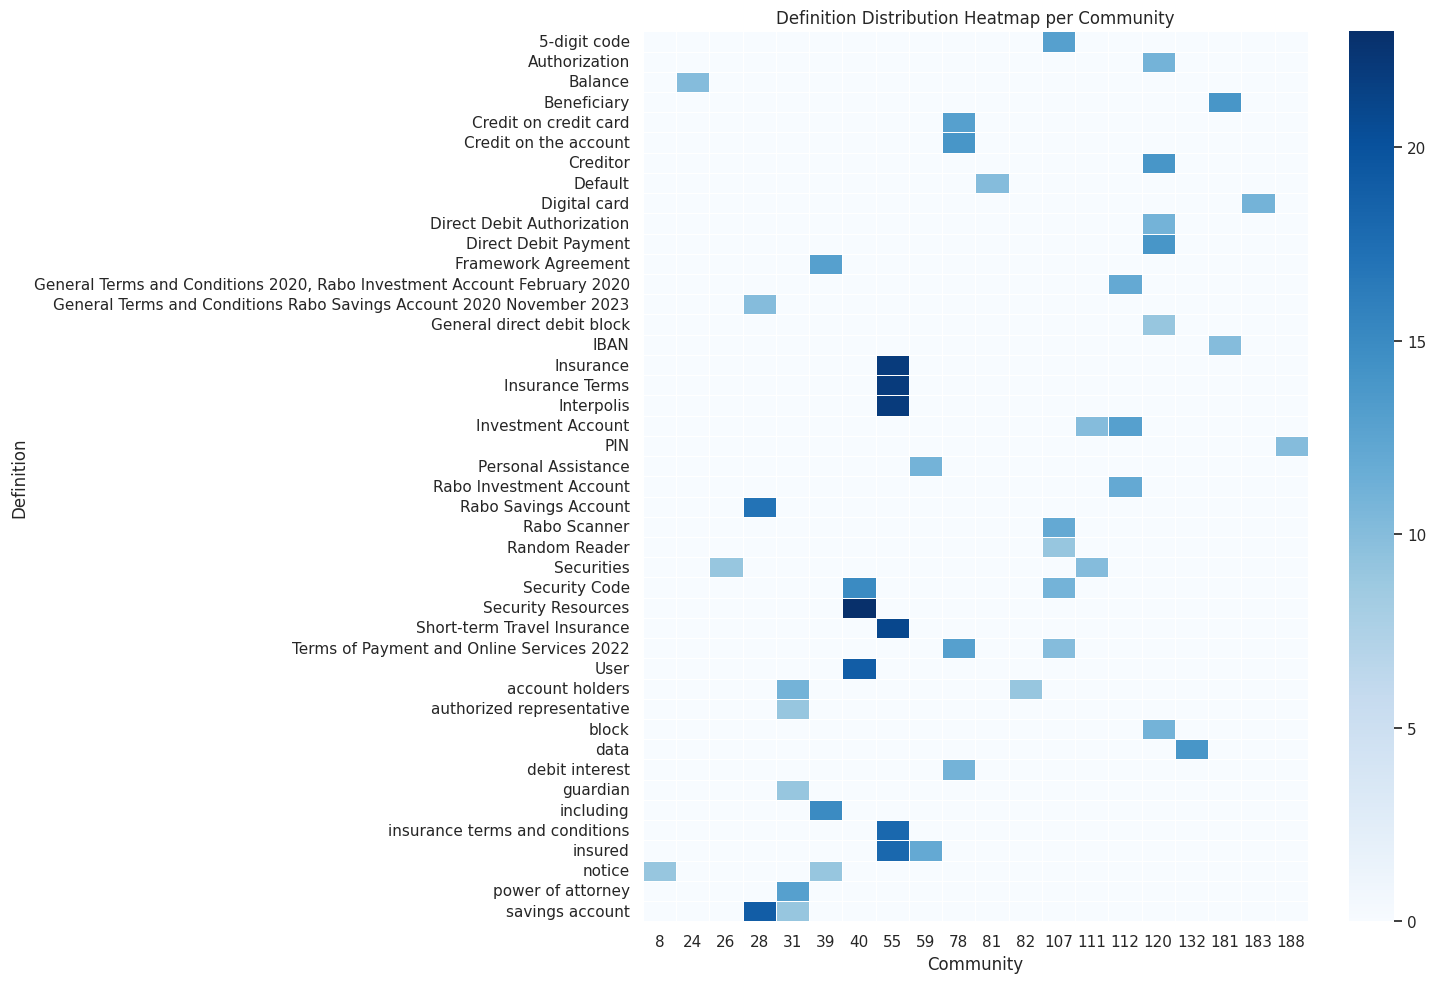

In [88]:
pivot_table = df.pivot(index="definition", columns="leiden_community", values="cnt").fillna(0).sort_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, cmap="Blues", yticklabels=True, linewidths=0.5)
plt.xlabel("Community")
plt.ylabel("Definition")
plt.title("Definition Distribution Heatmap per Community")
plt.tight_layout()
plt.show()